# Velocity plots

Loads adjusted data and then runs various plots for velocities, mean currents, and residual flows.

## Imports

In [19]:
# import modules

import xarray as xr
import cmocean
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as pldates
import scipy.signal as sig
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
for i in range(2):
    %matplotlib notebook

In [20]:
# import data

adcp = 'Axis75'     # Slope(2013,2014,2017,2018), Axis75(2013,2014), Axis55(2017,2018)
year = 2013
ds_in = xr.open_dataset(f'../Data/data/adj/adj_{adcp}_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    ds = [ds_in]
    for i in range(n_seg):
        if i > 0:
            ds_temp = xr.open_dataset(f'../Data/data/adj/adj_{adcp}_{year}_{i}.nc')
            ds.append(ds_temp)
elif n_seg == 1:
    ds = [ds_in]
    
#print(ds[0])

In [21]:
# extract plotting variables

t_stamp = ds[0].t_stamp
depth = ds[0].depth.values
d = len(depth)
start_date = ds[0].start_date
end_date = ds[0].end_date

# get WKB scale for site specific depth range

scaling_array = np.load('../project/archive/N2/scaling_array.npy')
GM_depths = scaling_array[0]                                 # depths range from -4 to -980 metres
GM_scale = scaling_array[1]
int_scale = np.interp(depth,-GM_depths,GM_scale)

## Adjusted, low-pass, high-pass

### Adjusted

<IPython.core.display.Javascript object>


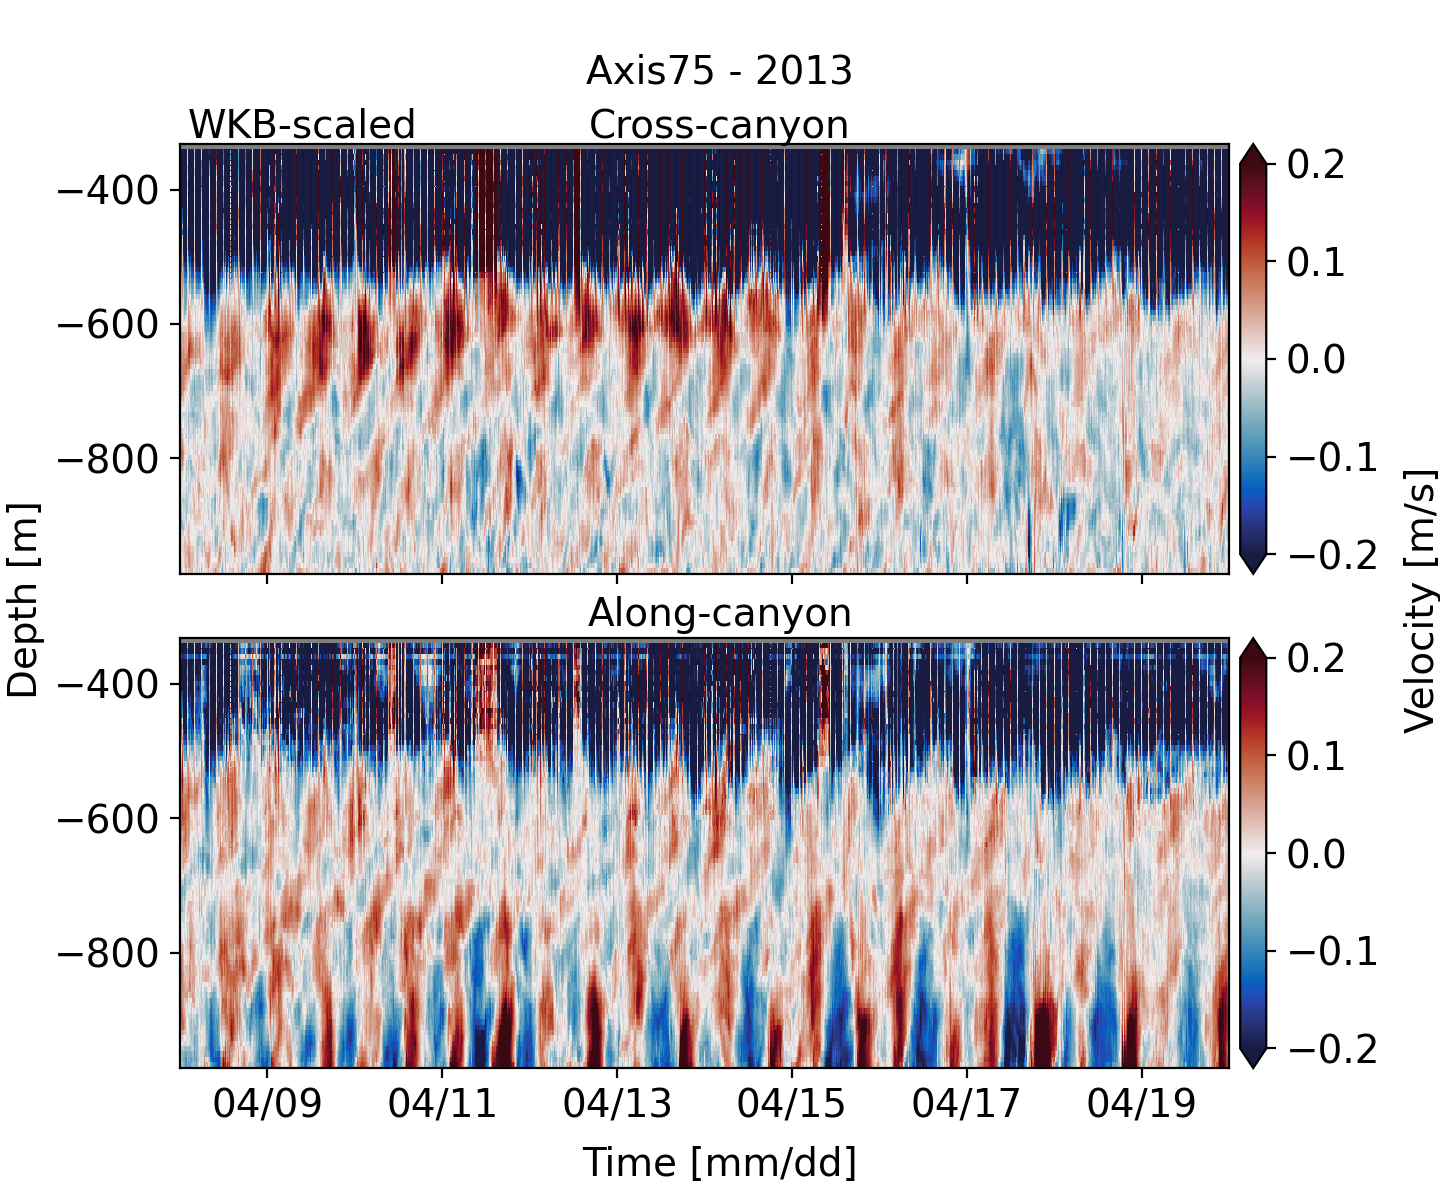

In [22]:
# plot adjusted velocity data

# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(ds[i].uorig[:,j].values / np.sqrt(int_scale[j]))          # list[depth][frequency]
        v_WKB_temp.append(ds[i].vorig[:,j].values / np.sqrt(int_scale[j]))          # list[depth][frequency]
    u_WKB_np = np.asarray(u_WKB_temp)
    v_WKB_np = np.asarray(v_WKB_temp)
    u_WKB.append(u_WKB_np)
    v_WKB.append(v_WKB_np)

fig, (ax0,ax1) = plt.subplots(2,1, figsize=(7.2,6), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0.15)
fig.text(0.5, 0.93, f'{adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.975, 0.5, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.02, 'Time [mm/dd]', ha='center',fontsize=14)
fig.text(0.21, 0.885, 'WKB-scaled', ha='center',fontsize=14)

if adcp == 'Slope':
    vmin = -0.15
    vmax = 0.15
    fig.text(0.5, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-slope', ha='center', fontsize=14)
elif adcp == 'Axis55' or adcp == 'Axis75':
    vmin = -0.2
    vmax = 0.2
    fig.text(0.5, 0.885, 'Cross-canyon', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-canyon', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].t_seg, -depth, u_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax,shading='auto')
    im1 = ax1.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax,shading='auto')

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')
    
date_form = pldates.DateFormatter("%m/%d")
ax1.xaxis.set_major_formatter(date_form)
if adcp == 'Axis55' and t_stamp == '2017':
    ax1.set_xlim(f'{t_stamp}-12-15',f'{t_stamp}-12-31')
else:
    ax1.set_xlim(f'{t_stamp}-04-08',f'{t_stamp}-04-20')
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)
plt.show()

#plt.savefig(fname=f'./plots/vel_plots/vel_{adcp}_{t_stamp}.pdf',format='pdf')

### Mean currents

<IPython.core.display.Javascript object>


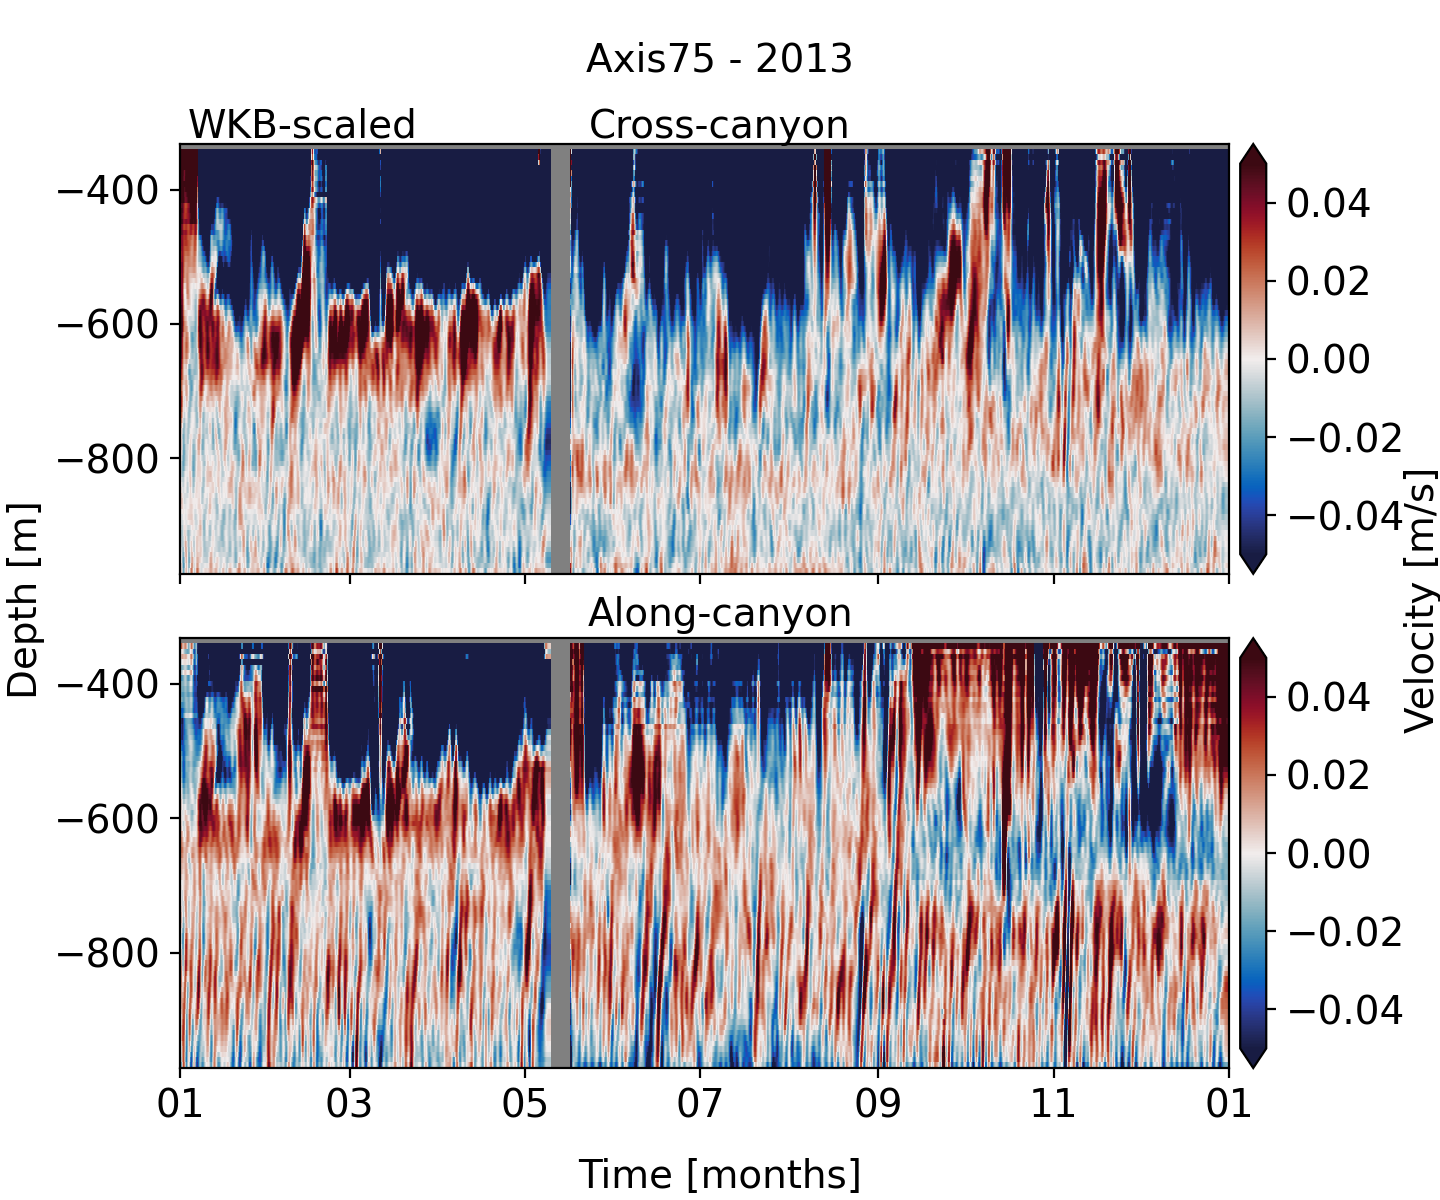

In [13]:
# plot mean current data

# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(ds[i].ulp[:,j].values / np.sqrt(int_scale[j]))         # list[depth][frequency]
        v_WKB_temp.append(ds[i].vlp[:,j].values / np.sqrt(int_scale[j]))          # list[depth][frequency]
    u_WKB_np = np.asarray(u_WKB_temp)
    v_WKB_np = np.asarray(v_WKB_temp)
    u_WKB.append(u_WKB_np)
    v_WKB.append(v_WKB_np)

# plot mean current data

fig, (ax0,ax1) = plt.subplots(2,1, figsize=(7.2,6), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0.15)
fig.text(0.5, 0.94, f'{adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.005, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.975, 0.5, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
fig.text(0.21, 0.885, 'WKB-scaled', ha='center',fontsize=14)

if adcp == 'Slope':
    vmin = -0.15
    vmax = 0.15
    fig.text(0.5, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-slope', ha='center', fontsize=14)
elif adcp == 'Axis55' or adcp == 'Axis75':
    vmin = -0.05
    vmax = 0.05
    fig.text(0.5, 0.885, 'Cross-canyon', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-canyon', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].t_seg, -depth, u_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
    im1 = ax1.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')
    
date_form = pldates.DateFormatter("%m")
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/vel_plots/lp_{adcp}_{t_stamp}.pdf',format='pdf')
#plt.savefig(fname=f'./plots/vel_plots/lp_{adcp}_{t_stamp}.png',format='png')

# save lp data to .nc for inter-annual comparison
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            ulp_WKB=(['depth','t_seg'], u_WKB[i]),        # low-pass data
            vlp_WKB=(['depth','t_seg'], v_WKB[i]),
        ),
        coords=dict(
            depth=depth,                        # depth values
            t_seg=ds[i].t_seg.values,           # datetime values in segments
        ),
        attrs=dict(
            description=f'Low-pass WKB velocity data for {adcp} {t_stamp} segment {i} (from 0 to {n_seg - 1}).',
            adcp=adcp,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            t_stamp=t_stamp,             # year stamp
            start_date=f'{start_date}',  # start date
            end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'../Data/interannual/vel_lp_{adcp}_{t_stamp}_{i}.nc')

### High-pass

In [ ]:
# plot residual flow data

# get residual flow data

uhp,vhp = [],[]
for i in range(n_seg):
    uhp_seg = ds[i].uorig - ds[i].ulp
    uhp.append(np.asarray(uhp_seg.values))
    vhp_seg = ds[i].vorig - ds[i].vlp
    vhp.append(np.asarray(vhp_seg.values)) 

# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(uhp[i][:,j] / np.sqrt(int_scale[j]))          # list[depth][frequency]
        v_WKB_temp.append(vhp[i][:,j] / np.sqrt(int_scale[j]))          # list[depth][frequency]
    u_WKB_np = np.asarray(u_WKB_temp)
    v_WKB_np = np.asarray(v_WKB_temp)
    u_WKB.append(u_WKB_np)
    v_WKB.append(v_WKB_np)
    
# plot
    
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(13,4.5), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0.15)
#fig.text(0.5, 0.94, f'{adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.925, 0.5, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [mm/dd]', ha='center',fontsize=14)
fig.text(0.17, 0.885, 'WKB-scaled', ha='center',fontsize=14)

if adcp == 'Slope':
    vmin = -0.15
    vmax = 0.15
    fig.text(0.5, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-slope', ha='center', fontsize=14)
elif adcp == 'Axis55' or adcp == 'Axis75':
    vmin = -0.3
    vmax = 0.3
    fig.text(0.5, 0.885, 'Cross-canyon', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-canyon', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].t_seg, -depth, u_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
    im1 = ax1.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
    if adcp == 'Axis75' or adcp == 'Axis55':
        ax0.hlines(y=-650, xmin=ds[i].start_date,xmax=ds[i].end_date, linewidth=1, color='black', ls='--')
        ax1.hlines(y=-650, xmin=ds[i].start_date,xmax=ds[i].end_date, linewidth=1, color='black', ls='--')

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')

date_form = pldates.DateFormatter("%m/%d")
ax1.xaxis.set_major_formatter(date_form)
if adcp == 'Axis55' and t_stamp == '2017':
    ax1.set_xlim(f'{t_stamp}-12-15',f'{t_stamp}-12-31')
else:
    ax1.set_xlim(f'{t_stamp}-04-08',f'{t_stamp}-04-20')
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/vel_plots/hp_{adcp}_{t_stamp}.pdf',format='pdf')
#plt.savefig(fname=f'./plots/vel_plots/hp_{adcp}_{t_stamp}.png',format='png')

## Band-filtered velocities

In [23]:
# choose frequency band

ubp,vbp = [],[]   # empty lists for filtered data
f_band = 'test'                         # Diurnal, Inertial, Semidiurnal, Continuum

for i in range(n_seg):
    d = ds[i].d
    t = len(ds[i].t_seg)
    fs = 1.111e-3                               # samples per SECOND for entire time series
    if f_band == 'Inertial':
        Wn = [1.35e-5,2.00e-5]                              # cut-off frequencies
    elif f_band == 'Diurnal':
        Wn = [0.90e-5,1.40e-5]
    elif f_band == 'Semidiurnal':
        Wn = [2.00e-5,2.50e-5]
    elif f_band == 'Subdiurnal':
        Wn = [2.00e-6,0.9e-5]
    elif f_band == 'Continuum':
        Wn = [7.00e-5,1.20e-4]
    elif f_band == 'test':
        Wn = [1.20e-4,5.0e-4]
    sos = sig.butter(8, Wn,'bandpass', fs=fs, output='sos')   # digital butterworth filter
    w,h = sig.sosfreqz(sos)                      # to plot filter response

    ubp_temp = np.empty([t,d])                  # empty array for low-pass filtered u values
    vbp_temp = np.empty([t,d])                  # empty array for low-pass filtered v values

    for j in range(d):                                 # loop for filtered and residual velocities
        ufilt = np.copy(ds[i].uorig[:,j].values)       # copy unfiltered array
        ubp_temp[:,j] = sig.sosfiltfilt(sos, ufilt)    # apply band pass filter

        vfilt = np.copy(ds[i].vorig[:,j].values)       # repeat for v
        vbp_temp[:,j] = sig.sosfiltfilt(sos, vfilt)

    ubp.append(ubp_temp)
    vbp.append(vbp_temp)

<IPython.core.display.Javascript object>


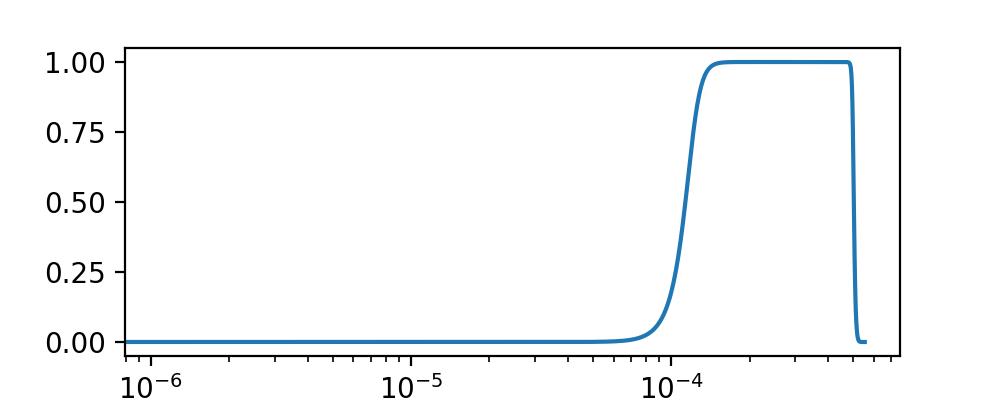

In [24]:
# plot filter response
fig,ax = plt.subplots(1,1,figsize=(5,2))
ax.semilogx(w*fs/(2*np.pi),abs(h))
plt.show()

<IPython.core.display.Javascript object>


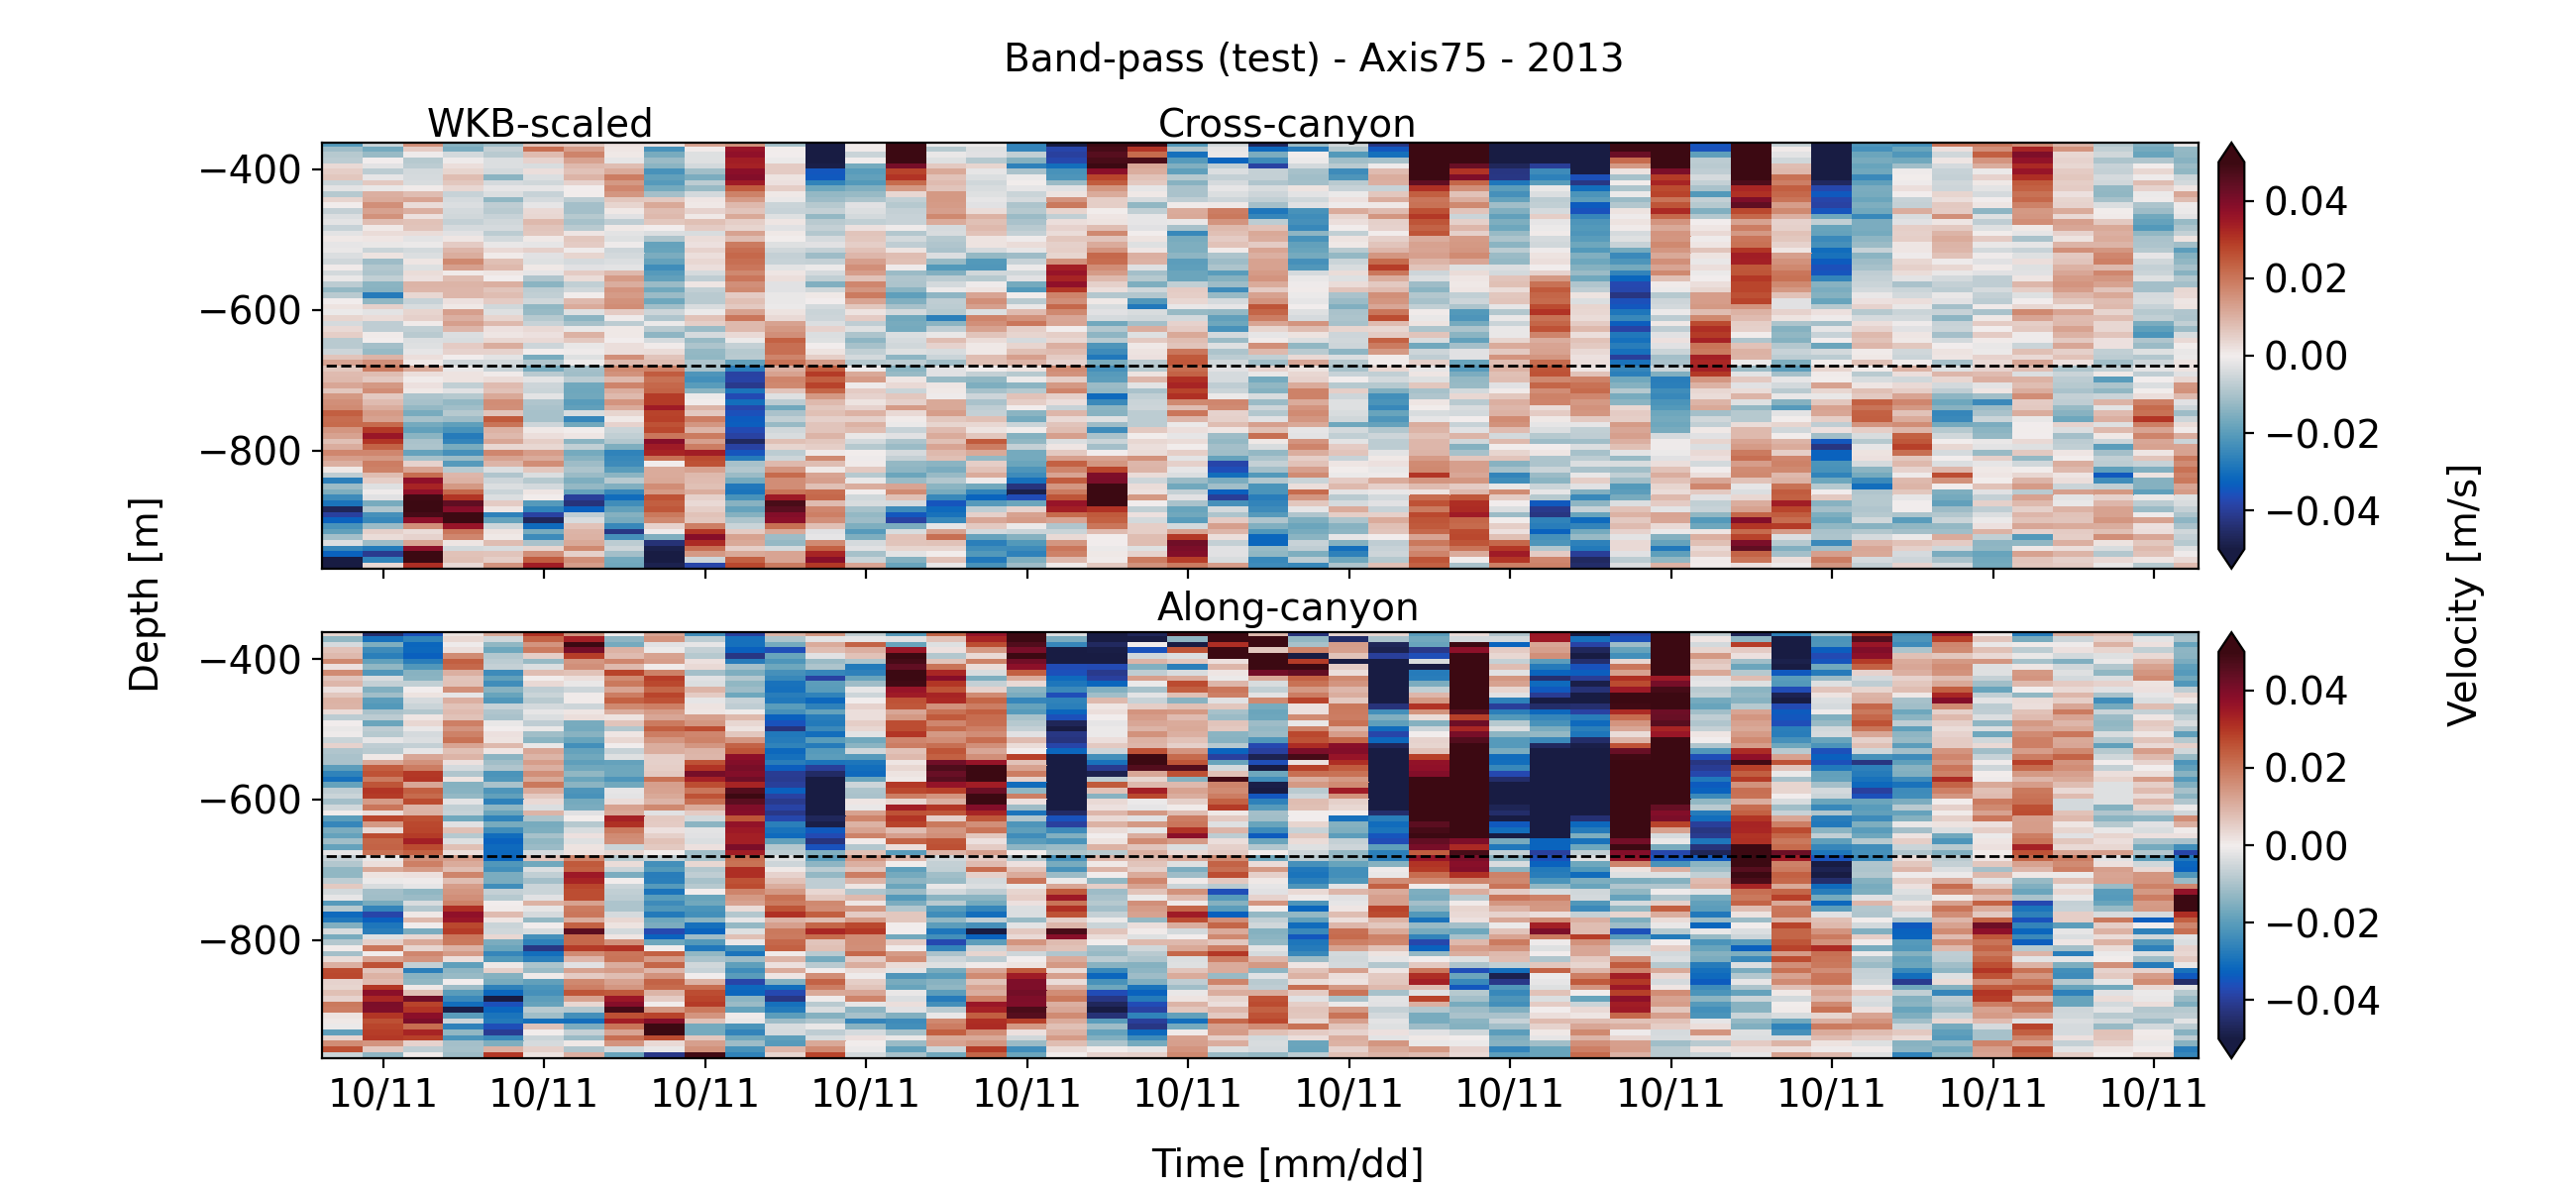

<ipython-input-25-0f6add4b751d>:66: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = ax0.pcolormesh(ds[i].t_seg, -depth, u_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax)
<ipython-input-25-0f6add4b751d>:67: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax)
<ipython-input-25-0f6add4b751d>:66: MatplotlibDeprecationWarning: shading='f

In [25]:
# plot bandpass current data

# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(ubp[i][:,j] / np.sqrt(int_scale[j]))          # list[depth][frequency]
        v_WKB_temp.append(vbp[i][:,j] / np.sqrt(int_scale[j]))          # list[depth][frequency]
    u_WKB_np = np.asarray(u_WKB_temp)
    v_WKB_np = np.asarray(v_WKB_temp)
    u_WKB.append(u_WKB_np)
    v_WKB.append(v_WKB_np)

fig, (ax0,ax1) = plt.subplots(2,1, figsize=(13,6), sharex = True, sharey = True)
fig.subplots_adjust(hspace = 0.15)
fig.text(0.51, 0.94, f'Band-pass ({f_band}) - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [mm/dd]', ha='center',fontsize=14)
fig.text(0.21, 0.885, 'WKB-scaled', ha='center',fontsize=14)

if adcp == 'Slope':
    fig.text(0.5, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-slope', ha='center', fontsize=14)
    if f_band == 'Inertial':
        vmin = -0.025
        vmax = 0.025
    elif f_band == 'Diurnal':
        vmin = -0.025
        vmax = 0.025
    elif f_band == 'Semidiurnal':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'Subdiurnal':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'Continuum':
        vmin = -0.025
        vmax = 0.025
    
elif adcp == 'Axis55' or adcp == 'Axis75':
    fig.text(0.5, 0.885, 'Cross-canyon', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-canyon', ha='center', fontsize=14)
    if f_band == 'Inertial':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'Diurnal':
        vmin = -0.1
        vmax = 0.1
    elif f_band == 'Semidiurnal':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'Subdiurnal':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'Continuum':
        vmin = -0.05
        vmax = 0.05
    elif f_band == 'test':
        vmin = -0.05
        vmax = 0.05

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].t_seg, -depth, u_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax)
    im1 = ax1.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax)
    if adcp == 'Axis75' or adcp == 'Axis55':
        ax0.plot(ds[i].t_seg,np.full(len(ds[i].t_seg),-680),color='black',ls='--',lw='1')
        ax1.plot(ds[i].t_seg,np.full(len(ds[i].t_seg),-680),color='black',ls='--',lw='1')

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')
    
date_form = pldates.DateFormatter("%m/%d")
ax1.xaxis.set_major_formatter(date_form)
if adcp == 'Axis55' and t_stamp == '2017':
    ax1.set_xlim(f'{t_stamp}-12-15',f'{t_stamp}-12-31')
else:
    ax1.set_xlim(f'{t_stamp}-10-08',f'{t_stamp}-10-12')
ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)

plt.show()

#plt.savefig(fname=f'./plots/vel_plots/bp_{f_band}_{adcp}_{t_stamp}.pdf',format='pdf')

## Along-canyon flow

In [ ]:
# WKB and average along-canyon velocity

# WKB scale at each depth

u_WKB,v_WKB = [],[]
for i in range(n_seg):
    u_WKB_temp,v_WKB_temp = [],[]
    for j in range(d):
        u_WKB_temp.append(ds[i].ulp[:,j].values / np.sqrt(int_scale[j]))         # list[depth][frequency]
        v_WKB_temp.append(ds[i].vlp[:,j].values / np.sqrt(int_scale[j]))          # list[depth][frequency]
    u_WKB_np = np.asarray(u_WKB_temp)
    v_WKB_np = np.asarray(v_WKB_temp)
    u_WKB.append(u_WKB_np)
    v_WKB.append(v_WKB_np)
    
# set depths for averaging

if adcp == 'Axis75':
    upper_d = 48
    lower_d = 71
    upper_depth = -depth[upper_d]
    lower_depth = -depth[lower_d-1]
elif adcp == 'Axis55':
    upper_d = 36
    lower_d = 45
    upper_depth = -depth[upper_d]
    lower_depth = -depth[lower_d-1]

v_avg = 0
tot_len = 0
weights = []

for i in range(n_seg):
    tot_len += len(v_WKB[i][upper_d])
print('Total length of time-series:',tot_len)
print('')

n_avg = 1400 # just over two weeks
v_avg_segs = []
v_depth_avg = []
for i in range(n_seg):
    v_avg_arr = np.asarray(v_WKB[i][upper_d:lower_d])
    print(np.nanmean(v_avg_arr))
    weights.append(len(v_avg_arr[0])/tot_len)
    print('Weight of segment',i,':',weights[i])
    v_avg += np.nanmean(v_avg_arr)*weights[i]
    
    da = xr.Dataset(
        data_vars=dict(
            v_WKB = (['depth','time'],v_WKB[i][upper_d:lower_d]),
        ),
        coords=dict(
            depth = -depth[upper_d:lower_d],
            time = ds[i].t_seg.values,
        ))
    
    v_depth_avg_temp = da.mean('depth')
    v_depth_avg.append(v_depth_avg_temp)
    
    if len(da.time) < n_avg:
        continue
    elif len(da.time) >= n_avg:
        da_roll_time = da.rolling(time=n_avg,center=True).mean().dropna('time')
        da_roll_depth = da_roll_time.mean('depth')
    
    v_avg_segs.append(da_roll_depth)

v_segs = len(v_avg_segs)
print('')
print(f'Annual average along-canyon velocity ({upper_depth} to {lower_depth} m): %.3f m/s' % v_avg)

In [ ]:
# plot canyon mean-current data for up-canyon flow

# plot mean current data

fig, (ax0,ax1,ax2) = plt.subplots(3,1, figsize=(13,6), sharex = True, sharey = False)
fig.subplots_adjust(hspace = 0.2)
fig.text(0.5, 0.885, f'40h low-pass - {adcp} - {t_stamp}', ha='center', fontsize=14)
fig.text(0.05, 0.65, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.05, 0.225, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.94, 0.65, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14)
#fig.text(0.5, 0.01, 'Time [mm/dd]', ha='center',fontsize=14)
fig.text(0.81, 0.885, 'WKB-scaled', ha='center',fontsize=14)

if adcp == 'Slope':
    vmin = -0.15
    vmax = 0.15
    fig.text(0.5, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.5, 0.478, 'Along-slope', ha='center', fontsize=14)
elif adcp == 'Axis55' or adcp == 'Axis75':
    vmin = -0.05
    vmax = 0.05
    fig.text(0.175, 0.885, 'Along-canyon', ha='center', fontsize=14)
    #fig.text(0.175, 0.615, 'Along-canyon', ha='center', fontsize=14)
    fig.text(0.73, 0.615, 'Annual mean velocity: %.3f m/s' % v_avg, ha='center', fontsize=14)
    #fig.text(0.175, 0.344, 'Along canyon', ha='center', fontsize=14)
    fig.text(0.77, 0.344, '2-week rolling average', ha='center', fontsize=14)

for i in range(n_seg):
    im0 = ax0.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
    im1 = ax1.pcolormesh(ds[i].t_seg, -depth, v_WKB[i], rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
for i in range(v_segs):
    im2 = ax2.plot(v_avg_segs[i].time,v_avg_segs[i].v_WKB,color='black')

cbar0 = fig.colorbar(im0, ax=ax0, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar0.ax.tick_params(labelsize=14)
cbar1.ax.tick_params(labelsize=14)

ax0.patch.set_facecolor('grey')
ax1.patch.set_facecolor('grey')
    
date_form = pldates.DateFormatter("%m")
#date_form = pldates.DateFormatter("%m/%d")
ax1.xaxis.set_major_formatter(date_form)

ax1.set_xlim(start_date,end_date)
#ax1.set_xlim(f'{t_stamp}-01-15',f'{t_stamp}-03-15')

ax0.tick_params(labelsize=14)
ax1.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax0.set_ylim(-depth[-1],-depth[0])
ax1.set_ylim(-depth[-1],-700)
ax2.set_ylim(-0.005,0.025)

ax2.set_box_aspect(0.1435)
ax2.set_anchor('W')

ax0.axhline(y= -depth[upper_d], color='black', linestyle='--')
ax0.axhline(y= -depth[lower_d-1], color='black', linestyle='--')
ax1.axhline(y= -depth[upper_d], color='black', linestyle='--')
ax1.axhline(y= -depth[lower_d-1], color='black', linestyle='--')

plt.show()

plt.savefig(fname=f'./plots/vel_plots/lp_canyon_{adcp}_{t_stamp}.pdf',format='pdf')

In [ ]:
# get Slope mean velocities

# import data

site2 = 'Slope'     # Slope or Axis

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site2 == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/vel_lp_{site2}_2013_0.nc'))
#     ds_2014.append(xr.open_dataset(f'../Data/interannual/vel_lp_{site2}_2014_0.nc'))
#     ds_2017.append(xr.open_dataset(f'../Data/interannual/vel_lp_{site2}_2017_0.nc'))
#     ds_2017.append(xr.open_dataset(f'../Data/interannual/vel_lp_{site2}_2017_1.nc'))
#     ds_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_{site2}_2018_0.nc'))

In [ ]:
# get semidiurnal mean power

# import data

site3 = 'Axis'     # Slope or Axis

ds2_2013,ds2_2014,ds2_2017,ds2_2018 = [],[],[],[]
if site3 == 'Axis':
    ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Semidiurnal_Axis75_2013_0.nc'))
    ds2_2013.append(xr.open_dataset(f'../Data/interannual/depthband_psd_Semidiurnal_Axis75_2013_1.nc'))
#     ds2_2014.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis75_2014_0.nc'))
#     ds2_2014.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis75_2014_1.nc'))
#     ds2_2014.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis75_2014_2.nc'))
#     ds2_2017.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2017_0.nc'))
#     ds2_2017.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2017_1.nc'))
#     ds2_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_0.nc'))
#     ds2_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_1.nc'))
#     ds2_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_2.nc'))
#     ds2_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_3.nc'))
#     ds2_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_4.nc'))
#     ds2_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_5.nc'))

In [ ]:
# compare with spring-neap forcing

f_name = 'Diurnal'
dst = xr.open_dataset(f'../Data/tide/tide_{f_name}_{t_stamp}.nc')
f_name2 = 'Semidiurnal'
dst_semi = xr.open_dataset(f'../Data/tide/tide_{f_name2}_{t_stamp}.nc')

fig,ax=plt.subplots(1,1,figsize=(13,5))
ax.set_title('Along-canyon mean-flow forcing comparisons',fontsize=14)

for i in range(v_segs):
    if i == 0:
        ax.plot(v_depth_avg[i].time,v_depth_avg[i].v_WKB,color='black',label='Along-canyon depth-mean (700-900 m) low-pass',lw=3)
    else:
        ax.plot(v_depth_avg[i].time,v_depth_avg[i].v_WKB,color='black',lw=3)
#ax.plot(dst.time,dst.tide/3,label=f'{f_name} spring-neap (scaled)',lw=1)
#ax.plot(dst_semi.time,dst_semi.tide/18,label=f'{f_name2} spring-neap (scaled)',lw=1)
ax.plot(dst.time,(dst.tide + dst_semi.tide)/20,label=f'Spring-neap surface levels (scaled)',lw=1)
for i in range(ds_2013[0].n_seg):
    if i == 0:
        ax.plot(ds_2013[i].t_seg, ds_2013[i].vlp_WKB[6:,:].mean('depth')/3,label='Along-slope depth-mean (50-350 m) low-pass (scaled)',lw=1)
    else:
        ax.plot(ds_2013[i].t_seg, ds_2013[i].vlp_WKB[6:,:].mean('depth')/3,lw=1)
for i in range(ds_2013[0].n_seg):
    if i == 0:
        ax.plot(ds2_2013[i].spect_s, ds2_2013[i].v_WKB[48:72,:].mean('depth')*40,label='Along-canyon depth-mean (700-900 m) semidiurnal PSD (scaled)',lw=1)
    else:
        ax.plot(ds2_2013[i].spect_s, ds2_2013[i].v_WKB[48:72,:].mean('depth')*40,lw=1)

ax.set_xlim(np.datetime64(f'{t_stamp}-01-15'),np.datetime64(f'{t_stamp}-06-15'))
ax.set_ylim(-0.03,0.08)
ax.legend()
plt.show()

plt.savefig(fname=f'./plots/vel_plots/lp_canyon_compare2_{adcp}_{t_stamp}.pdf',format='pdf')

## Inter-annual comparisons

In [ ]:
# import data

site = 'Axis'     # Slope or Axis

ds_2013,ds_2014,ds_2017,ds_2018 = [],[],[],[]
if site == 'Slope':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/vel_lp_{site}_2013_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/vel_lp_{site}_2014_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/vel_lp_{site}_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/vel_lp_{site}_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_{site}_2018_0.nc'))
elif site == 'Axis':
    ds_2013.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis75_2013_0.nc'))
    ds_2013.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis75_2013_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis75_2014_0.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis75_2014_1.nc'))
    ds_2014.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis75_2014_2.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2017_0.nc'))
    ds_2017.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2017_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_0.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_1.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_2.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_3.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_4.nc'))
    ds_2018.append(xr.open_dataset(f'../Data/interannual/vel_lp_Axis55_2018_5.nc'))
    
#print(ds_2018[0])

In [ ]:
# plot inter-annual data

fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5),(ax6,ax7)) = plt.subplots(4,2, figsize=(13,9), sharex = False, sharey = True)
fig.subplots_adjust(wspace = 0.08)
fig.text(0.51, 0.92, f'40h low-pass - {site}', ha='center', fontsize=14)
fig.text(0.05, 0.5, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.95, 0.5, 'Velocity [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.04, 'Time [months]', ha='center',fontsize=14)
fig.text(0.835, 0.886, 'WKB-scaled', ha='center',fontsize=14)
fig.text(0.142, 0.886, '2013', ha='center',fontsize=14)
fig.text(0.142, 0.683, '2014', ha='center',fontsize=14)
fig.text(0.142, 0.482, '2017', ha='center',fontsize=14)
fig.text(0.142, 0.281, '2018', ha='center',fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

if site == 'Slope':
    vmin = -0.2
    vmax = 0.2
    fig.text(0.31, 0.886, 'Cross-slope', ha='center', fontsize=14)
    fig.text(0.71, 0.886, 'Along-slope', ha='center', fontsize=14)
elif site == 'Axis':
    vmin = -0.05
    vmax = 0.05
    fig.text(0.31, 0.886, 'Cross-canyon', ha='center', fontsize=14)
    fig.text(0.71, 0.886, 'Along-canyon', ha='center', fontsize=14)

date_form = pldates.DateFormatter("%m")
years = [ds_2013,ds_2014,ds_2017,ds_2018]    
for k,i in enumerate(years):
    n_seg_temp = i[0].n_seg
    for j in range(n_seg_temp):
        if k == 0:
            im0 = ax0.pcolormesh(i[j].t_seg, -i[j].depth, i[j].ulp_WKB, rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
            im1 = ax1.pcolormesh(i[j].t_seg, -i[j].depth, i[j].vlp_WKB, rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
            ax0.xaxis.set_major_formatter(date_form)
            ax0.set_xlim(i[0].start_date,i[0].end_date)
            ax1.xaxis.set_major_formatter(date_form)
            ax1.set_xlim(i[0].start_date,i[0].end_date)
            ax0.hlines(y=-650, xmin=i[0].start_date,xmax=i[0].end_date, linewidth=1, color='black', ls='--')
            ax1.hlines(y=-650, xmin=i[0].start_date,xmax=i[0].end_date, linewidth=1, color='black', ls='--')
        elif k == 1:
            im2 = ax2.pcolormesh(i[j].t_seg, -i[j].depth, i[j].ulp_WKB, rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
            im3 = ax3.pcolormesh(i[j].t_seg, -i[j].depth, i[j].vlp_WKB, rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
            ax2.xaxis.set_major_formatter(date_form)
            ax2.set_xlim(i[0].start_date,i[0].end_date)
            ax3.xaxis.set_major_formatter(date_form)
            ax3.set_xlim(i[0].start_date,i[0].end_date)
            ax2.hlines(y=-650, xmin=i[0].start_date,xmax=i[0].end_date, linewidth=1, color='black', ls='--')
            ax3.hlines(y=-650, xmin=i[0].start_date,xmax=i[0].end_date, linewidth=1, color='black', ls='--')
        elif k == 2:
            im4 = ax4.pcolormesh(i[j].t_seg, -i[j].depth, i[j].ulp_WKB, rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
            im5 = ax5.pcolormesh(i[j].t_seg, -i[j].depth, i[j].vlp_WKB, rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
            ax4.xaxis.set_major_formatter(date_form)
            ax4.set_xlim(i[0].start_date,i[0].end_date)
            ax5.xaxis.set_major_formatter(date_form)
            ax5.set_xlim(i[0].start_date,i[0].end_date)
            ax4.hlines(y=-650, xmin=i[0].start_date,xmax=i[0].end_date, linewidth=1, color='black', ls='--')
            ax5.hlines(y=-650, xmin=i[0].start_date,xmax=i[0].end_date, linewidth=1, color='black', ls='--')
        elif k == 3:
            im6 = ax6.pcolormesh(i[j].t_seg, -i[j].depth, i[j].ulp_WKB, rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
            im7 = ax7.pcolormesh(i[j].t_seg, -i[j].depth, i[j].vlp_WKB, rasterized=True, cmap='cmo.balance', vmin=vmin, vmax=vmax, shading='auto')
            ax6.xaxis.set_major_formatter(date_form)
            ax6.set_xlim(i[0].start_date,i[0].end_date)
            ax7.xaxis.set_major_formatter(date_form)
            ax7.set_xlim(i[0].start_date,i[0].end_date)
            ax6.hlines(y=-650, xmin=i[0].start_date,xmax=i[0].end_date, linewidth=1, color='black', ls='--')
            ax7.hlines(y=-650, xmin=i[0].start_date,xmax=i[0].end_date, linewidth=1, color='black', ls='--')

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar3 = fig.colorbar(im3, ax=ax3, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar5 = fig.colorbar(im5, ax=ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar7 = fig.colorbar(im7, ax=ax7, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar1.ax.tick_params(labelsize=14)
cbar3.ax.tick_params(labelsize=14)
cbar5.ax.tick_params(labelsize=14)
cbar7.ax.tick_params(labelsize=14)

axs = [ax0,ax1,ax2,ax3,ax4,ax5,ax6,ax7]
ax7.set_ylim(-ds_2013[0].depth[-1],-ds_2013[0].depth[0])
for i in axs:
    i.patch.set_facecolor('grey')
    i.tick_params(labelsize=14)

plt.show()

plt.savefig(fname=f'./plots/interannual_plots/lp_vel_{site}.pdf',format='pdf')